# Setup StreetFighter

In [1]:
# Importing retro to play the Street Fighter using a ROM 
## Wowroms is one place to download the rom from
## Retro will only have the framework and the actual game rom needs to be downloaded
import retro
# Import time to slowdown game
import time

In [ ]:
# python -m retro.import . # register the game cartridge on the environment
# See the different reto games 
retro.data.list_games()

In [ ]:
# Importing the Street fighter rom downloaded from the wowroms
## We cannot run more than one instance of the game - to run mul instances run retrowrapper
env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis')

In [ ]:
# Review the game environment shape
env.observation_space.shape

In [ ]:
# Sample the actions that are availabe - multibinary
env.action_space.sample()

In [ ]:
import numpy as np

In [ ]:
np.zeros(12)

In [ ]:
# Starting the game needs a reset action
obs = env.reset()
# Set flag to false (will be used to track player's status
done = False
# Loop through the game 1 time
for game in range(1):
    while not done:
        if done:
            obs = env.reset()
        env.render()    
        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.01)
        print(reward)

In [ ]:
info

# Setup Environment
## Plan of action
- Preprocess the environment - 1. Capture Frame Delta. 2. Grayscale 3. Resize the frame so we have less pixels 
- Filter the actions - parameter
- Reward function - set this to score

In [ ]:
#1. Get the current frame
#2. Preprocess from 200*256*3 to 84*84*1 and Grayscale it
#3. Calculating the Delta (change in pixels) = current frame-last frame

In [2]:
# Import environment base class for a wrapper
from gym import Env
# Import the space shapes for the environment - multibinary is the expected input for the game and box is the frame
from gym.spaces import MultiBinary, Box
# Import numpy to calculate frame delta
import numpy as np
# Import opencv for grascaling
import cv2
# Importing the matplotlib to plot
from matplotlib import pyplot as plt

In [ ]:
Box(low=0, high=255, shape=(200, 256, 3), dtype=np.uint8)

In [ ]:
MultiBinary(12).sample()

In [3]:
# Create custom environment
class StreetFighter(Env):    
    def __init__(self):
        # Inherit base from
        super().__init__() 
        # Specify the observation space
        self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
        self.action_space = MultiBinary(12)
        # You can set the action space to discrete by passing through use_restricted_actions=retro.Actions.DISCRETE to the make method
        # Start up an instance of the game
        self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', 
                               use_restricted_actions=retro.Actions.FILTERED)

    def preprocess(self, observation):
        # Grayscale
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY) 
        # Resize the frame 
        resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
        # Add channels value using numpy wrappers
        channels = np.reshape(resize, (84,84,1))
        return channels

    def reset(self):
        # Returning the first frame
        obs = self.game.reset()
        # Preprocess
        obs = self.preprocess(obs)
        # current frame = previous frame
        self.previous_frame = obs
        # Create an attribute to hold the score delta
        self.score = 0    
        return obs
    
    def step(self, action):
        # Will take the step
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs)
        # Calculate the frame delta which captures the changes in pixels rather than pixels themselves
        frame_delta = obs - self.previous_frame
        self.prevous_frame = obs
        # Reshape the reward function
        reward = info['score'] - self.score
        self.score = info['score']
        return frame_delta, reward, done, info
        
    def render(self, *args, **kwargs):
        self.game.render()
        
    def close(self):
        self.game.close()

In [ ]:
env = StreetFighter()

In [ ]:
env.action_space.shape

In [ ]:
# Starting the game needs a reset action
obs = env.reset()
# Set flag to false (will be used to track player's status
done = False
# Loop through the game 1 time
for game in range(1):
    while not done:
        if done:
            obs = env.reset()
        env.render()    
        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.01)
        if reward > 0:
            print(reward)

In [ ]:
obs, reward, done, info = env.step(env.action_space.sample())

In [ ]:
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_RGB2BGR))

In [ ]:
info

In [ ]:
gray = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)

In [ ]:
resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)

In [ ]:
obs = np.reshape(resize, (84,84,1))

In [ ]:
obs, reward, done, info = env.step(env.action_space.sample())

In [ ]:
plt.imshow(obs)

# Hyperparameter tune
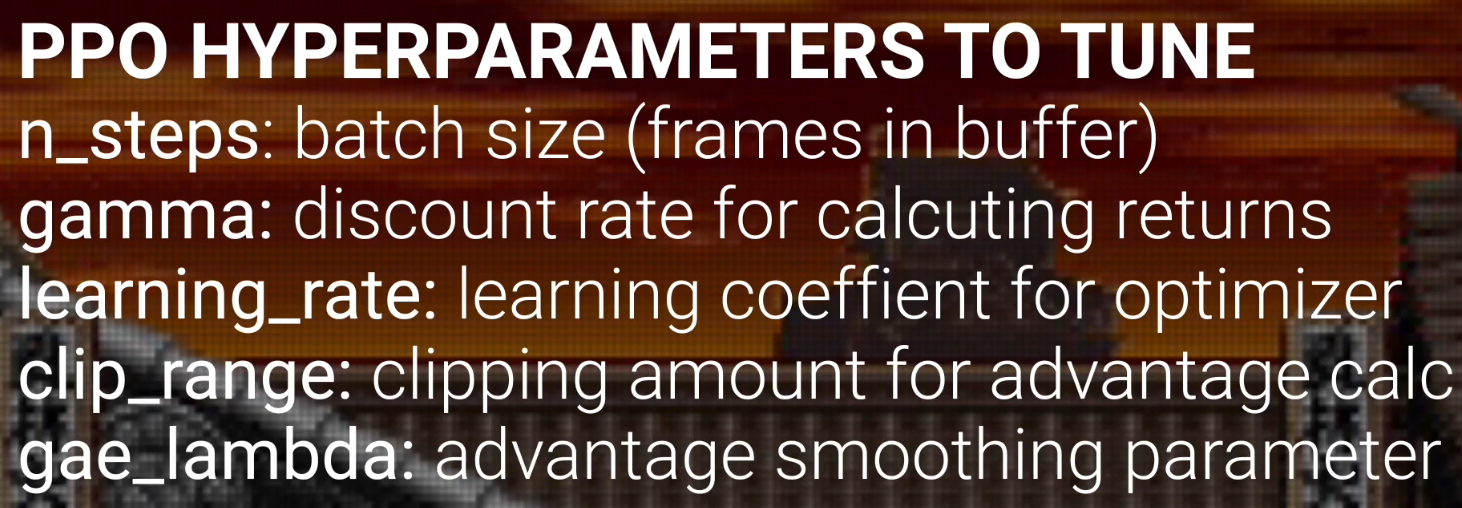

In [ ]:
#!pip install torch torchaudio torchvision stable-baseline3[extra]

In [ ]:
!pip install optuna

In [4]:
# Import optuna (optimization framework) for hyperparameter tuning
import optuna
# PPO algo used for training RL
from stable_baselines3 import PPO
# Eval policy method evaluates to test out kpis/metric calc for our agent 
from stable_baselines3.common.evaluation import evaluate_policy
# Import the SB3 monitor for logging
from stable_baselines3.common.monitor import Monitor
# Import the vec wrappers to vectorize and frame stack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
# Import os to deal with file paths
import os

D:\!Python Applications\RIFL\new_env_py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# sb3 can save logs which can viewed in tensorboard as well as onedb
LOG_DIR = './logs/StreetFighter/'
# when we perform hyperparameter optimization, we will set it up so it saves each model for every trial
## this will allow use to reload the model with the optimized paramters instead of training from start
OPT_DIR = './opt/StreetFighter/'

In [6]:
# Function to return a test hyperparameters -  define the objective function - thro this we can suggest what parameters type can be used
## paramter type could be float, int - read more at https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html
def optimize_ppo(trial):
    return {
        # n_steps - this is the number of frames that will be used for 1 batch of training 
        'n_steps': trial.suggest_int('n_steps', 2048, 8192),
        # Gamme is discount factor for future rewards, close to 0, immed reward will be considered strongly vs 1, future rewards 
        'gamma': trial.suggest_loguniform('gamma', 0.8, 0.9999),
        # How quickly agent (critic and actor from PPO algo) updates the estimates of value functions or action-values based on new info
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        # Used to limit the size of policy(i.e., rule that agent uses to decide which action to take) that updates (primarily associated with PPO)
        'clip_range': trial.suggest_float('clip_range', 0.1, 0.4),
        # gae = Generalized Advantage Estimation helps estimate advantage function 
        ## when you make a move in a game, how do we estimate that impact of that move on the whole game
        ## gae = 0, review immed result of that action, = 1, wait until game is finished
        'gae_lambda': trial.suggest_float('gae_lambda', 0.8, 0.99)
    }

In [7]:
# Run a training loop and return mean reward
def optimize_agent(trial):
    # Certain parameters will throw error, try except loop will allow the entire training run to complete
     try:
        model_params = optimize_ppo(trial)

        # Create environment
        env = StreetFighter()
        env = Monitor(env, LOG_DIR)

        # VecFrameStack needs some vectorized env to start (vectorized env can run multiple instances in parallel
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, 4, channels_order='last')
        
        # Create algo
        model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **model_params)
        model.learn(total_timesteps=300)
        
        #Evaluate model
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=1)
        env.close()

        SAVE_PATH = os.path.join(OPT_DIR, 'train_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        
        return mean_reward
    
     except Exception as e:
         return -1000

In [8]:
# Starting the experiment/study and training
## direction maximize will tend towards increasing mean_reward)
study = optuna.create_study(direction='maximize')
# n_jobs - how many parallel envs to train at the same time - gym_retro will not allow parallelization
study.optimize(optimize_agent, n_trials=1, n_jobs=1)

[I 2024-07-24 13:58:13,962] A new study created in memory with name: no-name-8faa1c18-e2a4-4c86-831c-412cc0142f29
C:\Users\chara\AppData\Local\Temp\ipykernel_1576\2600608059.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.8, 0.9999),
C:\Users\chara\AppData\Local\Temp\ipykernel_1576\2600608059.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
D:\!Python Applications\RIFL\new_env_py38\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_env

In [9]:
study.best_trial

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[2000.0], datetime_start=datetime.datetime(2024, 7, 24, 13, 58, 13, 964410), datetime_complete=datetime.datetime(2024, 7, 24, 14, 2, 5, 962313), params={'n_steps': 7438, 'gamma': 0.9990391526285698, 'learning_rate': 6.412339901359602e-05, 'clip_range': 0.16100471305419797, 'gae_lambda': 0.8313153593083179}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_steps': IntDistribution(high=8192, log=False, low=2048, step=1), 'gamma': FloatDistribution(high=0.9999, log=True, low=0.8, step=None), 'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-05, step=None), 'clip_range': FloatDistribution(high=0.4, log=False, low=0.1, step=None), 'gae_lambda': FloatDistribution(high=0.99, log=False, low=0.8, step=None)}, trial_id=0, value=None)

In [10]:
study.best_params

{'n_steps': 7438,
 'gamma': 0.9990391526285698,
 'learning_rate': 6.412339901359602e-05,
 'clip_range': 0.16100471305419797,
 'gae_lambda': 0.8313153593083179}

In [13]:
model = PPO.load(os.path.join(OPT_DIR,'train_0_best_model.zip'))

# Setup Callback|

In [15]:
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class TrainingLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainingLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_StreetFighter_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [16]:
CHECKPOINT_DIR = './train/'

In [ ]:
callback = TrainingLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Train Model

In [ ]:
# Create environment
env = StreetFighter()
env = Monitor(env, LOG_DIR)

# VecFrameStack needs some vectorized env to start (vectorized env can run multiple instances in parallel
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [17]:
model_params = study.best_params

In [18]:
model_params

{'n_steps': 7438,
 'gamma': 0.9990391526285698,
 'learning_rate': 6.412339901359602e-05,
 'clip_range': 0.16100471305419797,
 'gae_lambda': 0.8313153593083179}

In [20]:
7438/64 #n_steps should be a multiple of 64

116.21875

In [25]:
model_params['n_steps'] = 117 * 64

In [26]:
model_params

{'n_steps': 7488,
 'gamma': 0.9990391526285698,
 'learning_rate': 6.412339901359602e-05,
 'clip_range': 0.16100471305419797,
 'gae_lambda': 0.8313153593083179}

In [27]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, **model_params)

NameError: name 'env' is not defined

In [ ]:
# Loading the model that is pre-trained and performed better previously #TRANSFERLEARNING
model.load(os.path.join(OPT_DIR,'train_0_best_model.zip'))

In [ ]:
model.learn(total_timesteps=30000, callback=callback)

# Evaluate the Model

In [ ]:
model = PPO.load('./train/best_model_70000.zip')

In [ ]:
mean_reward, _ = evaluate_policy(model, 

# Test out the Model

In [ ]:
env.close()
del env